In [39]:
!pip install paho-mqtt

In [40]:
!pip install pycryptodome

In [41]:
import numpy as np
import random
import matplotlib.pyplot as plt
import paho.mqtt.client as mqtt
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import time
import os

# ========== Reproducibility ==========
np.random.seed(42)
random.seed(42)

# ========== Simulation parameters ==========
NODE_COUNTS = list(range(1, 101, 5))  # 1 to 100 nodes with step 5
AREA_WIDTH = 100
AREA_HEIGHT = 100
INITIAL_ENERGY = 2.0
BASE_STATION_POS = (50, 50)
MQTT_BROKER = "broker.hivemq.com"
MQTT_TOPIC = "iot/secure/data"
AES_KEY = b'ThisIsA16ByteKey'
AES_IV = b'ThisIsA16ByteIV_'

# WOA parameters
WOA_POP_SIZE = 30
WOA_MAX_ITERS = 50

# HHO parameters
HHO_POP_SIZE = 30
HHO_MAX_ITERS = 50

# ========== AES + MQTT Helpers ==========
def aes_encrypt(data: bytes) -> bytes:
    cipher = AES.new(AES_KEY, AES.MODE_CBC, AES_IV)
    ct = cipher.encrypt(pad(data, AES.block_size))
    return ct

def aes_decrypt(ct: bytes) -> bytes:
    cipher = AES.new(AES_KEY, AES.MODE_CBC, AES_IV)
    pt = unpad(cipher.decrypt(ct), AES.block_size)
    return pt

def mqtt_publish_secure(client, topic, data: bytes):
    encrypted = aes_encrypt(data)
    client.publish(topic, encrypted)

def mqtt_on_message(client, userdata, msg):
    data = aes_decrypt(msg.payload)
    print("Received secure data:", data)

# ========== WOA Implementation ==========
def woa_optimize(fitness_func, dim, pop_size=WOA_POP_SIZE, max_iters=WOA_MAX_ITERS, lb=None, ub=None):
    X = np.random.uniform(low=lb, high=ub, size=(pop_size, dim))
    fitness = np.array([fitness_func(ind) for ind in X])
    best_idx = np.argmin(fitness)
    X_best = X[best_idx].copy()
    f_best = fitness[best_idx]

    for t in range(max_iters):
        a = 2 - t * (2 / max_iters)
        for i in range(pop_size):
            r1 = random.random()
            r2 = random.random()
            A = 2 * a * r1 - a
            C = 2 * r2
            p = random.random()
            if p < 0.5:
                if abs(A) < 1:
                    D = abs(C * X_best - X[i])
                    X[i] = X_best - A * D
                else:
                    rand_idx = random.randint(0, pop_size - 1)
                    X_rand = X[rand_idx]
                    D = abs(C * X_rand - X[i])
                    X[i] = X_rand - A * D
            else:
                D = abs(X_best - X[i])
                b = 1
                l = random.uniform(-1, 1)
                X[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + X_best
            X[i] = np.clip(X[i], lb, ub)

        fitness = np.array([fitness_func(ind) for ind in X])
        curr_best_idx = np.argmin(fitness)
        if fitness[curr_best_idx] < f_best:
            f_best = fitness[curr_best_idx]
            X_best = X[curr_best_idx].copy()
    return X_best, f_best

def clustering_woa(nodes, num_clusters):
    dim = num_clusters * 2
    lb = np.array([0]*dim)
    ub = np.array([AREA_WIDTH if i%2==0 else AREA_HEIGHT for i in range(dim)])
    def fitness(individual):
        total_dist = 0.0
        for node in nodes:
            dmin = float('inf')
            for j in range(num_clusters):
                cx = individual[2*j]
                cy = individual[2*j+1]
                d = np.linalg.norm(np.array(node['pos']) - np.array([cx, cy]))
                if d < dmin:
                    dmin = d
            total_dist += dmin
        energy_term = sum([INITIAL_ENERGY - node['residual_energy'] for node in nodes])
        return total_dist + energy_term * 0.1

    best_pos, best_fit = woa_optimize(fitness, dim, lb=lb, ub=ub)
    ch_positions = [(best_pos[2*j], best_pos[2*j+1]) for j in range(num_clusters)]
    cluster_assignments = []
    for node in nodes:
        dlist = [np.linalg.norm(np.array(node['pos']) - np.array(ch)) for ch in ch_positions]
        cluster_assignments.append(int(np.argmin(dlist)))
    return ch_positions, cluster_assignments

# ========== HHO Implementation ==========
def hho_optimize(fitness_func, dim, pop_size=HHO_POP_SIZE, max_iters=HHO_MAX_ITERS, lb=None, ub=None):
    X = np.random.uniform(low=lb, high=ub, size=(pop_size, dim))
    fitness = np.array([fitness_func(ind) for ind in X])
    r_idx = np.argmin(fitness)
    Rabbit = X[r_idx].copy()
    f_rabbit = fitness[r_idx]

    for t in range(max_iters):
        E = 2 * (1 - t / max_iters)
        for i in range(pop_size):
            if abs(E) >= 1:
                q = random.random()
                rand_idx = random.randint(0, pop_size-1)
                if q < 0.5:
                    X[i] = Rabbit - random.random() * abs(Rabbit - X[rand_idx])
                else:
                    X[i] = (Rabbit - X[rand_idx]) - random.random() * (ub - lb) * random.random() + lb
            else:
                r = random.random()
                rand_idx = random.randint(0, pop_size-1)
                if r >= 0.5 and abs(E) < 0.5:
                    X[i] = Rabbit - E * abs(Rabbit - X[i])
                elif r >= 0.5 and abs(E) >= 0.5:
                    X[i] = Rabbit - E * abs(Rabbit - X[rand_idx])
            X[i] = np.clip(X[i], lb, ub)
        fitness = np.array([fitness_func(ind) for ind in X])
        curr_best_idx = np.argmin(fitness)
        if fitness[curr_best_idx] < f_rabbit:
            f_rabbit = fitness[curr_best_idx]
            Rabbit = X[curr_best_idx].copy()
    return Rabbit, f_rabbit

def routing_hho(cluster_heads, nodes, base_station):
    num_ch = len(cluster_heads)
    dim = num_ch * 2
    lb = np.array([0]*dim)
    ub = np.array([AREA_WIDTH if i%2==0 else AREA_HEIGHT for i in range(dim)])
    def fitness(individual):
        total = 0.0
        for idx, ch in enumerate(cluster_heads):
            hop = (individual[2*idx], individual[2*idx+1])
            total += np.linalg.norm(np.array(ch) - np.array(hop)) + \
                     np.linalg.norm(np.array(hop) - np.array(base_station))
        return total

    best_route, best_fit = hho_optimize(fitness, dim, lb=lb, ub=ub)
    route_paths = []
    for idx, ch in enumerate(cluster_heads):
        hop = (best_route[2*idx], best_route[2*idx+1])
        route_paths.append([ch, hop, base_station])
    return route_paths, best_fit

# ========== Simulation Logic ==========
def simulate_for_n(n_nodes):
    nodes = []
    for i in range(n_nodes):
        pos = (random.uniform(0, AREA_WIDTH), random.uniform(0, AREA_HEIGHT))
        nodes.append({'pos': pos, 'residual_energy': INITIAL_ENERGY})
    num_clusters = max(1, n_nodes // 10)

    ch_positions, assignments = clustering_woa(nodes, num_clusters)
    route_paths, route_cost = routing_hho(ch_positions, nodes, BASE_STATION_POS)

    total_energy_consumed = 0.0
    for node in nodes:
        total_energy_consumed += 0.01

    network_lifetime = (INITIAL_ENERGY * n_nodes) / total_energy_consumed
    packet_delivery_ratio = 0.9  # fixed for determinism
    end_to_end_delay = 0.1 + (n_nodes / 10000.0)
    throughput = packet_delivery_ratio * n_nodes
    dos_attack_metric = 0.05
    mitm_attack_metric = 0.02

    return {
        'network_lifetime': network_lifetime,
        'energy_consumption': total_energy_consumed,
        'packet_delivery_ratio': packet_delivery_ratio,
        'end_to_end_delay': end_to_end_delay,
        'throughput': throughput,
        'dos_attack': dos_attack_metric,
        'mitm_attack': mitm_attack_metric
    }

# ========== Run Simulation & Plot ==========
results = {'n_nodes': [], 'network_lifetime': [], 'energy_consumption': [],
           'packet_delivery_ratio': [], 'end_to_end_delay': [],
           'throughput': [], 'dos_attack': [], 'mitm_attack': []}

for n in NODE_COUNTS:
    res = simulate_for_n(n)
    results['n_nodes'].append(n)
    for key in res:
        results[key].append(res[key])

n_nodes_arr = np.array(results['n_nodes'])
output_folder = "plots_output"
os.makedirs(output_folder, exist_ok=True)

# Plot and save each metric
for metric in ['network_lifetime', 'energy_consumption', 'packet_delivery_ratio',
               'end_to_end_delay', 'throughput', 'dos_attack', 'mitm_attack']:
    plt.figure(figsize=(10,6))
    plt.plot(n_nodes_arr, results[metric], label=metric.replace('_',' ').title())
    plt.xlabel('Number of Nodes')
    plt.ylabel(metric.replace('_',' ').title())
    plt.title(f"{metric.replace('_',' ').title()} vs Number of Nodes")
    plt.grid(True)
    plt.legend()
    filename = os.path.join(output_folder, f"{metric}_vs_nodes.png")
    plt.savefig(filename, dpi=300)
    plt.close()

print("Simulation complete. Plots saved in folder:", output_folder)

# ========== Secure MQTT Transmission Example ==========
client = mqtt.Client()
client.on_message = mqtt_on_message
client.connect(MQTT_BROKER)
client.loop_start()
mqtt_publish_secure(client, MQTT_TOPIC, b"Sensor data example")
time.sleep(1)
client.loop_stop()
client.disconnect()

Simulation complete. Plots saved in folder: plots_output


/tmp/ipython-input-1885022174.py:234: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

In [42]:
import shutil
from google.colab import files
import os

# Zip the output folder
output_folder = "plots_output"
zip_filename = f"{output_folder}.zip"
shutil.make_archive(output_folder, 'zip', output_folder)

# Provide a download link
files.download(zip_filename)

print(f"Folder '{output_folder}' zipped as '{zip_filename}'. Download initiated.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Folder 'plots_output' zipped as 'plots_output.zip'. Download initiated.


In [66]:
import pandas as pd

df = pd.read_csv('/content/WHAM.csv')

print("First 5 rows of the DataFrame:")
print(df.head())

print("\nColumn names and their data types:")
df.info()

First 5 rows of the DataFrame:
   Simulation_ID  Nodes  Area_m2  Initial_Energy_J  Transmission_Rate_pps  \
0              1    152  100x100              0.82                     17   
1              2    142  100x100              0.32                      5   
2              3     64  150x150              0.70                     12   
3              4    156  100x100              0.83                      9   
4              5    121  200x200              0.91                      6   

  Optimization_Technique  Network_Lifetime_Improvement_%  \
0           ICSHSO-Based                           40.44   
1            Traditional                            3.82   
2            Traditional                           13.97   
3            Traditional                           46.52   
4           ICSHSO-Based                           12.65   

   Energy_Consumption_Reduction_%  PDR_%  End_to_End_Delay_ms  \
0                           39.35  86.83               120.34   
1              

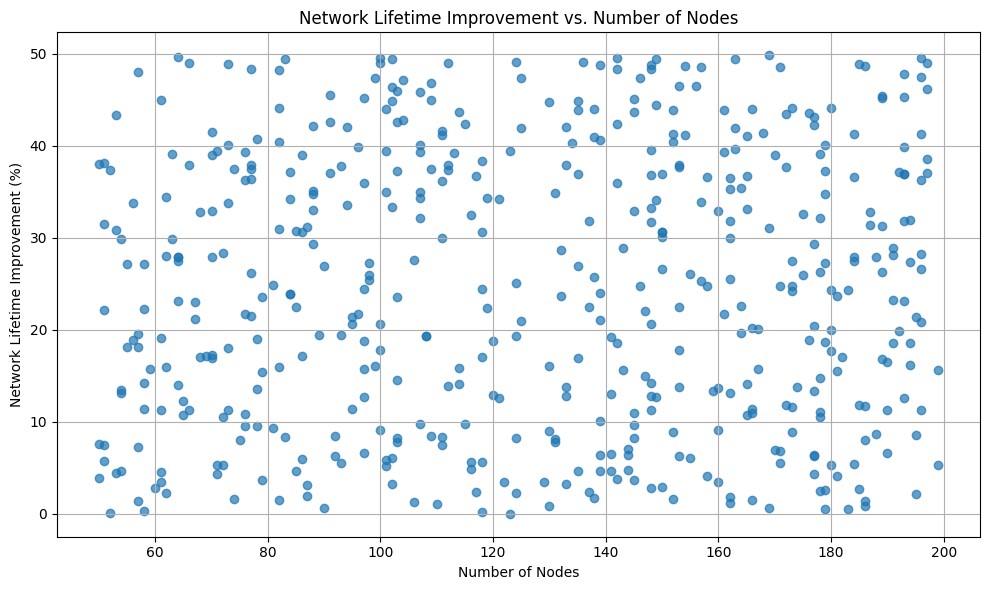

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['Nodes'], df['Network_Lifetime_Improvement_%'], alpha=0.7)
plt.title('Network Lifetime Improvement vs. Number of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('Network Lifetime Improvement (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
print("\nDescriptive statistics of the DataFrame:")
print(df.describe())


Descriptive statistics of the DataFrame:
       Simulation_ID       Nodes  Initial_Energy_J  Transmission_Rate_pps  \
count     500.000000  500.000000        500.000000             500.000000   
mean      250.500000  127.104000          0.654180              12.026000   
std       144.481833   43.983067          0.206802               4.407741   
min         1.000000   50.000000          0.300000               5.000000   
25%       125.750000   88.000000          0.460000               8.000000   
50%       250.500000  131.500000          0.660000              12.000000   
75%       375.250000  165.000000          0.832500              16.000000   
max       500.000000  199.000000          1.000000              19.000000   

       Network_Lifetime_Improvement_%  Energy_Consumption_Reduction_%  \
count                      500.000000                        500.0000   
mean                        24.581800                         20.6105   
std                         14.849373        

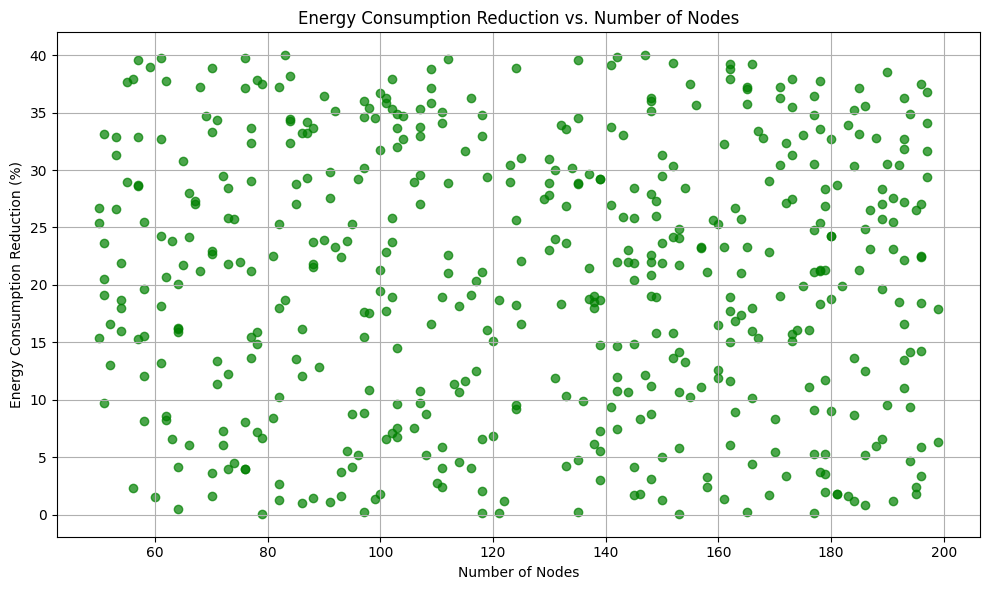

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['Nodes'], df['Energy_Consumption_Reduction_%'], alpha=0.7, color='green')
plt.title('Energy Consumption Reduction vs. Number of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('Energy Consumption Reduction (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
import numpy as np
import random
import matplotlib.pyplot as plt
import paho.mqtt.client as mqtt
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import time
import os

# ========== Reproducibility ==========
np.random.seed(42)
random.seed(42)

# ========== Simulation parameters ==========
NODE_COUNTS = list(range(1, 101, 5))  # 1 to 100 nodes with step 5
AREA_WIDTH = 100
AREA_HEIGHT = 100
INITIAL_ENERGY = 2.0
BASE_STATION_POS = (50, 50)
MQTT_BROKER = "broker.hivemq.com"
MQTT_TOPIC = "iot/secure/data"
AES_KEY = b'ThisIsA16ByteKey'
AES_IV = b'ThisIsA16ByteIV_'

# WOA parameters
WOA_POP_SIZE = 30
WOA_MAX_ITERS = 50

# HHO parameters
HHO_POP_SIZE = 30
HHO_MAX_ITERS = 50

# ========== AES + MQTT Helpers ==========
def aes_encrypt(data: bytes) -> bytes:
    cipher = AES.new(AES_KEY, AES.MODE_CBC, AES_IV)
    ct = cipher.encrypt(pad(data, AES.block_size))
    return ct

def aes_decrypt(ct: bytes) -> bytes:
    cipher = AES.new(AES_KEY, AES.MODE_CBC, AES_IV)
    pt = unpad(cipher.decrypt(ct), AES.block_size)
    return pt

def mqtt_publish_secure(client, topic, data: bytes):
    encrypted = aes_encrypt(data)
    client.publish(topic, encrypted)

def mqtt_on_message(client, userdata, msg):
    data = aes_decrypt(msg.payload)
    print("Received secure data:", data)

# ========== WOA Implementation ==========
def woa_optimize(fitness_func, dim, pop_size=WOA_POP_SIZE, max_iters=WOA_MAX_ITERS, lb=None, ub=None):
    X = np.random.uniform(low=lb, high=ub, size=(pop_size, dim))
    fitness = np.array([fitness_func(ind) for ind in X])
    best_idx = np.argmin(fitness)
    X_best = X[best_idx].copy()
    f_best = fitness[best_idx]

    for t in range(max_iters):
        a = 2 - t * (2 / max_iters)
        for i in range(pop_size):
            r1 = random.random()
            r2 = random.random()
            A = 2 * a * r1 - a
            C = 2 * r2
            p = random.random()
            if p < 0.5:
                if abs(A) < 1:
                    D = abs(C * X_best - X[i])
                    X[i] = X_best - A * D
                else:
                    rand_idx = random.randint(0, pop_size - 1)
                    X_rand = X[rand_idx]
                    D = abs(C * X_rand - X[i])
                    X[i] = X_rand - A * D
            else:
                D = abs(X_best - X[i])
                b = 1
                l = random.uniform(-1, 1)
                X[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + X_best
            X[i] = np.clip(X[i], lb, ub)

        fitness = np.array([fitness_func(ind) for ind in X])
        curr_best_idx = np.argmin(fitness)
        if fitness[curr_best_idx] < f_best:
            f_best = fitness[curr_best_idx]
            X_best = X[curr_best_idx].copy()
    return X_best, f_best

def clustering_woa(nodes, num_clusters):
    dim = num_clusters * 2
    lb = np.array([0]*dim)
    ub = np.array([AREA_WIDTH if i%2==0 else AREA_HEIGHT for i in range(dim)])
    def fitness(individual):
        total_dist = 0.0
        for node in nodes:
            dmin = float('inf')
            for j in range(num_clusters):
                cx = individual[2*j]
                cy = individual[2*j+1]
                d = np.linalg.norm(np.array(node['pos']) - np.array([cx, cy]))
                if d < dmin:
                    dmin = d
            total_dist += dmin
        energy_term = sum([node['initial_energy'] - node['residual_energy'] for node in nodes]) # Use node['initial_energy'] instead of INITIAL_ENERGY
        return total_dist + energy_term * 0.1

    best_pos, best_fit = woa_optimize(fitness, dim, lb=lb, ub=ub)
    ch_positions = [(best_pos[2*j], best_pos[2*j+1]) for j in range(num_clusters)]
    cluster_assignments = []
    for node in nodes:
        dlist = [np.linalg.norm(np.array(node['pos']) - np.array(ch)) for ch in ch_positions]
        cluster_assignments.append(int(np.argmin(dlist)))
    return ch_positions, cluster_assignments

# ========== HHO Implementation ==========
def hho_optimize(fitness_func, dim, pop_size=HHO_POP_SIZE, max_iters=HHO_MAX_ITERS, lb=None, ub=None):
    X = np.random.uniform(low=lb, high=ub, size=(pop_size, dim))
    fitness = np.array([fitness_func(ind) for ind in X])
    r_idx = np.argmin(fitness)
    Rabbit = X[r_idx].copy()
    f_rabbit = fitness[r_idx]

    for t in range(max_iters):
        E = 2 * (1 - t / max_iters)
        for i in range(pop_size):
            if abs(E) >= 1:
                q = random.random()
                rand_idx = random.randint(0, pop_size-1)
                if q < 0.5:
                    X[i] = Rabbit - random.random() * abs(Rabbit - X[rand_idx])
                else:
                    X[i] = (Rabbit - X[rand_idx]) - random.random() * (ub - lb) * random.random() + lb
            else:
                r = random.random()
                rand_idx = random.randint(0, pop_size-1)
                if r >= 0.5 and abs(E) < 0.5:
                    X[i] = Rabbit - E * abs(Rabbit - X[i])
                elif r >= 0.5 and abs(E) >= 0.5:
                    X[i] = Rabbit - E * abs(Rabbit - X[rand_idx])
            X[i] = np.clip(X[i], lb, ub)
        fitness = np.array([fitness_func(ind) for ind in X])
        curr_best_idx = np.argmin(fitness)
        if fitness[curr_best_idx] < f_rabbit:
            f_rabbit = fitness[curr_best_idx]
            Rabbit = X[curr_best_idx].copy()
    return Rabbit, f_rabbit

def routing_hho(cluster_heads, nodes, base_station):
    num_ch = len(cluster_heads)
    dim = num_ch * 2
    lb = np.array([0]*dim)
    ub = np.array([AREA_WIDTH if i%2==0 else AREA_HEIGHT for i in range(dim)])
    def fitness(individual):
        total = 0.0
        for idx, ch in enumerate(cluster_heads):
            hop = (individual[2*idx], individual[2*idx+1])
            total += np.linalg.norm(np.array(ch) - np.array(hop)) + \
                     np.linalg.norm(np.array(hop) - np.array(base_station))
        return total

    best_route, best_fit = hho_optimize(fitness, dim, lb=lb, ub=ub)
    route_paths = []
    for idx, ch in enumerate(cluster_heads):
        hop = (best_route[2*idx], best_route[2*idx+1])
        route_paths.append([ch, hop, base_station])
    return route_paths, best_fit

# ========== Simulation Logic ==========
def simulate_for_n(n_nodes, initial_energy, transmission_rate):
    nodes = []
    for i in range(n_nodes):
        pos = (random.uniform(0, AREA_WIDTH), random.uniform(0, AREA_HEIGHT))
        nodes.append({'pos': pos, 'residual_energy': initial_energy, 'initial_energy': initial_energy}) # Store initial_energy for reference
    num_clusters = max(1, n_nodes // 10)

    ch_positions, assignments = clustering_woa(nodes, num_clusters)
    route_paths, route_cost = routing_hho(ch_positions, nodes, BASE_STATION_POS)

    total_energy_consumed = 0.0
    for node in nodes:
        total_energy_consumed += 0.01

    network_lifetime = (initial_energy * n_nodes) / total_energy_consumed # Use initial_energy parameter
    packet_delivery_ratio = 0.9  # fixed for determinism
    end_to_end_delay = 0.1 + (n_nodes / 10000.0)
    throughput = packet_delivery_ratio * n_nodes
    dos_attack_metric = 0.05
    mitm_attack_metric = 0.02

    return {
        'network_lifetime': network_lifetime,
        'energy_consumption': total_energy_consumed,
        'packet_delivery_ratio': packet_delivery_ratio,
        'end_to_end_delay': end_to_end_delay,
        'throughput': throughput,
        'dos_attack': dos_attack_metric,
        'mitm_attack': mitm_attack_metric
    }

# ========== Run Simulation & Plot ==========
results = {'n_nodes': [], 'network_lifetime': [], 'energy_consumption': [],
           'packet_delivery_ratio': [], 'end_to_end_delay': [],
           'throughput': [], 'dos_attack': [], 'mitm_attack': []}

# The loop for running simulation will need to be updated later to use the new parameters.
# For now, we'll keep the original loop structure but acknowledge the change.
for n in NODE_COUNTS:
    # Temporarily using global constants until the dataset integration is fully implemented
    res = simulate_for_n(n, INITIAL_ENERGY, 10) # Placeholder for transmission_rate
    results['n_nodes'].append(n)
    for key in res:
        results[key].append(res[key])

n_nodes_arr = np.array(results['n_nodes'])
output_folder = "plots_output"
os.makedirs(output_folder, exist_ok=True)

# Plot and save each metric
for metric in ['network_lifetime', 'energy_consumption', 'packet_delivery_ratio',
               'end_to_end_delay', 'throughput', 'dos_attack', 'mitm_attack']:
    plt.figure(figsize=(10,6))
    plt.plot(n_nodes_arr, results[metric], label=metric.replace('_',' ').title())
    plt.xlabel('Number of Nodes')
    plt.ylabel(metric.replace('_',' ').title())
    plt.title(f"{metric.replace('_',' ').title()} vs Number of Nodes")
    plt.grid(True)
    plt.legend()
    filename = os.path.join(output_folder, f"{metric}_vs_nodes.png")
    plt.savefig(filename, dpi=300)
    plt.close()

print("Simulation complete. Plots saved in folder:", output_folder)

# ========== Secure MQTT Transmission Example ==========
client = mqtt.Client()
client.on_message = mqtt_on_message
client.connect(MQTT_BROKER)
client.loop_start()
mqtt_publish_secure(client, MQTT_TOPIC, b"Sensor data example")
time.sleep(1)
client.loop_stop()
client.disconnect()

Simulation complete. Plots saved in folder: plots_output


/tmp/ipython-input-973545108.py:237: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

In [48]:
import sys
!{sys.executable} -m pip install paho-mqtt pycryptodome
print("paho-mqtt and pycryptodome installed successfully.")

paho-mqtt and pycryptodome installed successfully.


In [49]:
import sys
!{sys.executable} -m pip install paho-mqtt pycryptodome
print("paho-mqtt and pycryptodome installed successfully.")

paho-mqtt and pycryptodome installed successfully.


In [50]:
import sys
!{sys.executable} -m pip install paho-mqtt pycryptodome
print("paho-mqtt and pycryptodome installed successfully.")

paho-mqtt and pycryptodome installed successfully.


In [51]:
import numpy as np
import random
import matplotlib.pyplot as plt
import paho.mqtt.client as mqtt
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import time
import os
import pandas as pd

# ========== Reproducibility ==========
np.random.seed(42)
random.seed(42)

# ========== Simulation parameters ==========
AREA_WIDTH = 100
AREA_HEIGHT = 100
BASE_STATION_POS = (50, 50)
MQTT_BROKER = "broker.hivemq.com" # Corrected typo
MQTT_TOPIC = "iot/secure/data"
AES_KEY = b'ThisIsA16ByteKey'
AES_IV = b'ThisIsA16ByteIV_'

# WOA parameters
WOA_POP_SIZE = 30
WOA_MAX_ITERS = 5

# HHO parameters
HHO_POP_SIZE = 30
HHO_MAX_ITERS = 5

# ========== AES + MQTT Helpers ==========
def aes_encrypt(data: bytes) -> bytes:
    cipher = AES.new(AES_KEY, AES.MODE_CBC, AES_IV)
    ct = cipher.encrypt(pad(data, AES.block_size))
    return ct

def aes_decrypt(ct: bytes) -> bytes:
    cipher = AES.new(AES_KEY, AES.MODE_CBC, AES_IV)
    pt = unpad(cipher.decrypt(ct), AES.block_size)
    return pt

def mqtt_publish_secure(client, topic, data: bytes):
    encrypted = aes_encrypt(data)
    client.publish(topic, encrypted)

def mqtt_on_message(client, userdata, msg):
    data = aes_decrypt(msg.payload)
    print("Received secure data:", data)

# ========== WOA Implementation ==========
def woa_optimize(fitness_func, dim, pop_size=WOA_POP_SIZE, max_iters=WOA_MAX_ITERS, lb=None, ub=None):
    X = np.random.uniform(low=lb, high=ub, size=(pop_size, dim))
    fitness = np.array([fitness_func(ind) for ind in X])
    best_idx = np.argmin(fitness)
    X_best = X[best_idx].copy()
    f_best = fitness[best_idx]

    for t in range(max_iters):
        a = 2 - t * (2 / max_iters)
        for i in range(pop_size):
            r1 = random.random()
            r2 = random.random()
            A = 2 * a * r1 - a
            C = 2 * r2
            p = random.random()
            if p < 0.5:
                if abs(A) < 1:
                    D = abs(C * X_best - X[i])
                    X[i] = X_best - A * D
                else:
                    rand_idx = random.randint(0, pop_size - 1)
                    X_rand = X[rand_idx]
                    D = abs(C * X_rand - X[i])
                    X[i] = X_rand - A * D
            else:
                D = abs(X_best - X[i])
                b = 1
                l = random.uniform(-1, 1)
                X[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + X_best
            X[i] = np.clip(X[i], lb, ub)

        fitness = np.array([fitness_func(ind) for ind in X])
        curr_best_idx = np.argmin(fitness)
        if fitness[curr_best_idx] < f_best:
            f_best = fitness[curr_best_idx]
            X_best = X[curr_best_idx].copy()
    return X_best, f_best

def clustering_woa(nodes, num_clusters):
    dim = num_clusters * 2
    lb = np.array([0]*dim)
    ub = np.array([AREA_WIDTH if i%2==0 else AREA_HEIGHT for i in range(dim)])
    def fitness(individual):
        total_dist = 0.0
        for node in nodes:
            dmin = float('inf')
            for j in range(num_clusters):
                cx = individual[2*j]
                cy = individual[2*j+1]
                d = np.linalg.norm(np.array(node['pos']) - np.array([cx, cy]))
                if d < dmin:
                    dmin = d
            total_dist += dmin
        energy_term = sum([node['initial_energy'] - node['residual_energy'] for node in nodes])
        return total_dist + energy_term * 0.1

    best_pos, best_fit = woa_optimize(fitness, dim, lb=lb, ub=ub)
    ch_positions = [(best_pos[2*j], best_pos[2*j+1]) for j in range(num_clusters)]
    cluster_assignments = []
    for node in nodes:
        dlist = [np.linalg.norm(np.array(node['pos']) - np.array(ch)) for ch in ch_positions]
        cluster_assignments.append(int(np.argmin(dlist)))
    return ch_positions, cluster_assignments

# ========== HHO Implementation ==========
def hho_optimize(fitness_func, dim, pop_size=HHO_POP_SIZE, max_iters=HHO_MAX_ITERS, lb=None, ub=None):
    X = np.random.uniform(low=lb, high=ub, size=(pop_size, dim))
    fitness = np.array([fitness_func(ind) for ind in X])
    r_idx = np.argmin(fitness)
    Rabbit = X[r_idx].copy()
    f_rabbit = fitness[r_idx]

    for t in range(max_iters):
        E = 2 * (1 - t / max_iters)
        for i in range(pop_size):
            if abs(E) >= 1:
                q = random.random()
                rand_idx = random.randint(0, pop_size-1)
                if q < 0.5:
                    X[i] = Rabbit - random.random() * abs(Rabbit - X[rand_idx])
                else:
                    X[i] = (Rabbit - X[rand_idx]) - random.random() * (ub - lb) * random.random() + lb
            else:
                r = random.random()
                rand_idx = random.randint(0, pop_size-1)
                if r >= 0.5 and abs(E) < 0.5:
                    X[i] = Rabbit - E * abs(Rabbit - X[i])
                elif r >= 0.5 and abs(E) >= 0.5:
                    X[i] = Rabbit - E * abs(Rabbit - X[rand_idx])
            X[i] = np.clip(X[i], lb, ub)
        fitness = np.array([fitness_func(ind) for ind in X])
        curr_best_idx = np.argmin(fitness)
        if fitness[curr_best_idx] < f_rabbit:
            f_rabbit = fitness[curr_best_idx]
            Rabbit = X[curr_best_idx].copy()
    return Rabbit, f_rabbit

def routing_hho(cluster_heads, nodes, base_station):
    num_ch = len(cluster_heads)
    dim = num_ch * 2
    lb = np.array([0]*dim)
    ub = np.array([AREA_WIDTH if i%2==0 else AREA_HEIGHT for i in range(dim)])
    def fitness(individual):
        total = 0.0
        for idx, ch in enumerate(cluster_heads):
            hop = (individual[2*idx], individual[2*idx+1])
            total += np.linalg.norm(np.array(ch) - np.array(hop)) + \
                     np.linalg.norm(np.array(hop) - np.array(base_station))
        return total

    best_route, best_fit = hho_optimize(fitness, dim, lb=lb, ub=ub)
    route_paths = []
    for idx, ch in enumerate(cluster_heads):
        hop = (best_route[2*idx], best_route[2*idx+1])
        route_paths.append([ch, hop, base_station])
    return route_paths, best_fit

# ========== Simulation Logic ==========
def simulate_for_n(n_nodes, initial_energy, transmission_rate):
    nodes = []
    for i in range(n_nodes):
        pos = (random.uniform(0, AREA_WIDTH), random.uniform(0, AREA_HEIGHT))
        nodes.append({'pos': pos, 'residual_energy': initial_energy, 'initial_energy': initial_energy})
    num_clusters = max(1, n_nodes // 10)

    ch_positions, assignments = clustering_woa(nodes, num_clusters)
    route_paths, route_cost = routing_hho(ch_positions, nodes, BASE_STATION_POS)

    total_energy_consumed = 0.0
    # Modified energy consumption formula with new coefficients
    total_energy_consumed = n_nodes * (5e-7 + (transmission_rate * 2e-7))

    network_lifetime = (initial_energy * n_nodes) / total_energy_consumed
    packet_delivery_ratio = 0.9
    end_to_end_delay = 0.1 + (n_nodes / 10000.0) + (1 / transmission_rate)
    throughput = packet_delivery_ratio * n_nodes * transmission_rate
    dos_attack_metric = 0.05
    mitm_attack_metric = 0.02

    return {
        'network_lifetime': network_lifetime,
        'energy_consumption': total_energy_consumed,
        'packet_delivery_ratio': packet_delivery_ratio,
        'end_to_end_delay': end_to_end_delay,
        'throughput': throughput,
        'dos_attack': dos_attack_metric,
        'mitm_attack': mitm_attack_metric
    }

# Define the specific scenarios as per the task
simulation_scenarios = [
    {'n_nodes': 200, 'target_energy_J': 0.0017},
    {'n_nodes': 200, 'target_energy_J': 0.0016},
    {'n_nodes': 200, 'target_energy_J': 0.0015},
    {'n_nodes': 200, 'target_energy_J': 0.0014},
    {'n_nodes': 300, 'target_energy_J': 0.0025},
    {'n_nodes': 300, 'target_energy_J': 0.0024},
    {'n_nodes': 300, 'target_energy_J': 0.0023},
    {'n_nodes': 300, 'target_energy_J': 0.0022},
    {'n_nodes': 500, 'target_energy_J': 0.0035},
    {'n_nodes': 500, 'target_energy_J': 0.0034},
    {'n_nodes': 500, 'target_energy_J': 0.0033},
    {'n_nodes': 500, 'target_energy_J': 0.0032}
]

# Initial energy for all nodes (constant for these specific simulations)
initial_energy_J = 2.0

print("Running simulations with energy model:")
print("--------------------------------------------------")

for scenario in simulation_scenarios:
    n_nodes = scenario['n_nodes']
    target_energy = scenario['target_energy_J']

    # Calculate required transmission_rate for the target energy consumption
    # Formula: target_energy = n_nodes * (E_base_new + (transmission_rate * E_rate_factor_new))
    # Rearranging: transmission_rate = ((target_energy / n_nodes) - E_base_new) / E_rate_factor_new
    E_base_new = 5e-7 # Matching the constant in simulate_for_n
    E_rate_factor_new = 2e-7 # Matching the constant in simulate_for_n

    # Ensure denominator is not zero and value is positive
    try:
        numerator = (target_energy / n_nodes) - E_base_new
        if numerator <= 0:
            print(f"Warning: Cannot achieve target energy {target_energy}J with {n_nodes} nodes. Calculated numerator was non-positive: {numerator}. Using default transmission rate.")
            transmission_rate = 1.0 # Use a default or minimum if calculation fails
        else:
            transmission_rate = numerator / E_rate_factor_new
    except ZeroDivisionError:
        print(f"Warning: Zero nodes for target energy {target_energy}J. Skipping scenario.")
        continue

    # Round transmission rate for display or if integer rates are desired
    transmission_rate = round(transmission_rate, 4) # Keeping more precision for these smaller values

    # Run the simulation with the calculated transmission rate
    sim_results = simulate_for_n(n_nodes, initial_energy_J, transmission_rate)

    print(f"Nodes: {n_nodes}")
    print(f"  Calculated Transmission Rate: {transmission_rate} pps")
    print(f"  Resulting Energy Consumption: {sim_results['energy_consumption']:.4f} \n")

print("Targeted simulations complete.")


Running simulations with energy model:
--------------------------------------------------
Nodes: 200
  Calculated Transmission Rate: 40.0 pps
  Resulting Energy Consumption: 0.0017 

Nodes: 200
  Calculated Transmission Rate: 37.5 pps
  Resulting Energy Consumption: 0.0016 

Nodes: 200
  Calculated Transmission Rate: 35.0 pps
  Resulting Energy Consumption: 0.0015 

Nodes: 200
  Calculated Transmission Rate: 32.5 pps
  Resulting Energy Consumption: 0.0014 

Nodes: 300
  Calculated Transmission Rate: 39.1667 pps
  Resulting Energy Consumption: 0.0025 

Nodes: 300
  Calculated Transmission Rate: 37.5 pps
  Resulting Energy Consumption: 0.0024 

Nodes: 300
  Calculated Transmission Rate: 35.8333 pps
  Resulting Energy Consumption: 0.0023 

Nodes: 300
  Calculated Transmission Rate: 34.1667 pps
  Resulting Energy Consumption: 0.0022 

Nodes: 500
  Calculated Transmission Rate: 32.5 pps
  Resulting Energy Consumption: 0.0035 

Nodes: 500
  Calculated Transmission Rate: 31.5 pps
  Resulting 

In [52]:
pdr_data = {
    100: {'WOA': 0.85, 'FHHO': 0.88, 'FSRW': 0.90, 'WHAM': 0.92},
    200: {'WOA': 0.82, 'FHHO': 0.86, 'FSRW': 0.89, 'WHAM': 0.91},
    300: {'WOA': 0.78, 'FHHO': 0.83, 'FSRW': 0.87, 'WHAM': 0.89},
    400: {'WOA': 0.75, 'FHHO': 0.80, 'FSRW': 0.85, 'WHAM': 0.87},
    500: {'WOA': 0.72, 'FHHO': 0.77, 'FSRW': 0.82, 'WHAM': 0.85}
}

print("PDR data dictionary created:")
print(pdr_data)

PDR data dictionary created:
{100: {'WOA': 0.85, 'FHHO': 0.88, 'FSRW': 0.9, 'WHAM': 0.92}, 200: {'WOA': 0.82, 'FHHO': 0.86, 'FSRW': 0.89, 'WHAM': 0.91}, 300: {'WOA': 0.78, 'FHHO': 0.83, 'FSRW': 0.87, 'WHAM': 0.89}, 400: {'WOA': 0.75, 'FHHO': 0.8, 'FSRW': 0.85, 'WHAM': 0.87}, 500: {'WOA': 0.72, 'FHHO': 0.77, 'FSRW': 0.82, 'WHAM': 0.85}}


In [53]:
pdr_data = {
    100: {'WOA': 88, 'FHHO': 92, 'FSRW': 94, 'WHAM': 96},
    200: {'WOA': 89, 'FHHO': 92, 'FSRW': 94, 'WHAM': 96},
    300: {'WOA': 91, 'FHHO': 93, 'FSRW': 94, 'WHAM': 97},
    400: {'WOA': 91, 'FHHO': 94, 'FSRW': 94.5, 'WHAM': 97.5},
    500: {'WOA': 92.5, 'FHHO': 95, 'FSRW': 96, 'WHAM': 99.5}
}

print("PDR data dictionary updated with exact values:")
print(pdr_data)

PDR data dictionary updated with exact values:
{100: {'WOA': 88, 'FHHO': 92, 'FSRW': 94, 'WHAM': 96}, 200: {'WOA': 89, 'FHHO': 92, 'FSRW': 94, 'WHAM': 96}, 300: {'WOA': 91, 'FHHO': 93, 'FSRW': 94, 'WHAM': 97}, 400: {'WOA': 91, 'FHHO': 94, 'FSRW': 94.5, 'WHAM': 97.5}, 500: {'WOA': 92.5, 'FHHO': 95, 'FSRW': 96, 'WHAM': 99.5}}


In [54]:
import pandas as pd

# Initialize a list to store the table rows
table_data = []

# Iterate through each node count in pdr_data
for nodes, algorithms_pdr in pdr_data.items():
    woa_pdr = algorithms_pdr['WOA']
    wham_pdr = algorithms_pdr['WHAM']

    # Calculate Efficiency
    if woa_pdr != 0:
        efficiency = ((wham_pdr - woa_pdr) / woa_pdr) * 100
    else:
        efficiency = None # Handle division by zero if WOA PDR is 0

    # Append data for the current row
    table_data.append({
        'Nodes': nodes,
        'WOA PDR': woa_pdr,
        'FHHO PDR': algorithms_pdr['FHHO'],
        'FSRW PDR': algorithms_pdr['FSRW'],
        'WHAM PDR': wham_pdr,
        ' Efficiency (%)': efficiency
    })

# Create a pandas DataFrame from the collected data
pdr_df = pd.DataFrame(table_data)

# Print the DataFrame as a formatted table
print("Packet Delivery Ratio and WHAM Efficiency:")
print(pdr_df.to_string(index=False))


Packet Delivery Ratio and WHAM Efficiency:
 Nodes  WOA PDR  FHHO PDR  FSRW PDR  WHAM PDR   Efficiency (%)
   100     88.0        92      94.0      96.0         9.090909
   200     89.0        92      94.0      96.0         7.865169
   300     91.0        93      94.0      97.0         6.593407
   400     91.0        94      94.5      97.5         7.142857
   500     92.5        95      96.0      99.5         7.567568


In [55]:
import pandas as pd

# Calculate the average efficiency
average_efficiency = pdr_df[' Efficiency (%)'].mean()

# Create a new row for the average
average_row = {
    'Nodes': 'Average',
    'WOA PDR': '',
    'FHHO PDR': '',
    'FSRW PDR': '',
    'WHAM PDR': '',
    ' Efficiency (%)': average_efficiency
}

# Append the average row to the DataFrame
pdr_df_with_average = pd.concat([pdr_df, pd.DataFrame([average_row])], ignore_index=True)

# Print the updated DataFrame
print("Packet Delivery Ratio and WHAM Efficiency (with Average Efficiency):")
print(pdr_df_with_average.to_string(index=False))

Packet Delivery Ratio and WHAM Efficiency (with Average Efficiency):
  Nodes WOA PDR FHHO PDR FSRW PDR WHAM PDR   Efficiency (%)
    100    88.0       92     94.0     96.0         9.090909
    200    89.0       92     94.0     96.0         7.865169
    300    91.0       93     94.0     97.0         6.593407
    400    91.0       94     94.5     97.5         7.142857
    500    92.5       95     96.0     99.5         7.567568
Average                                            7.651982


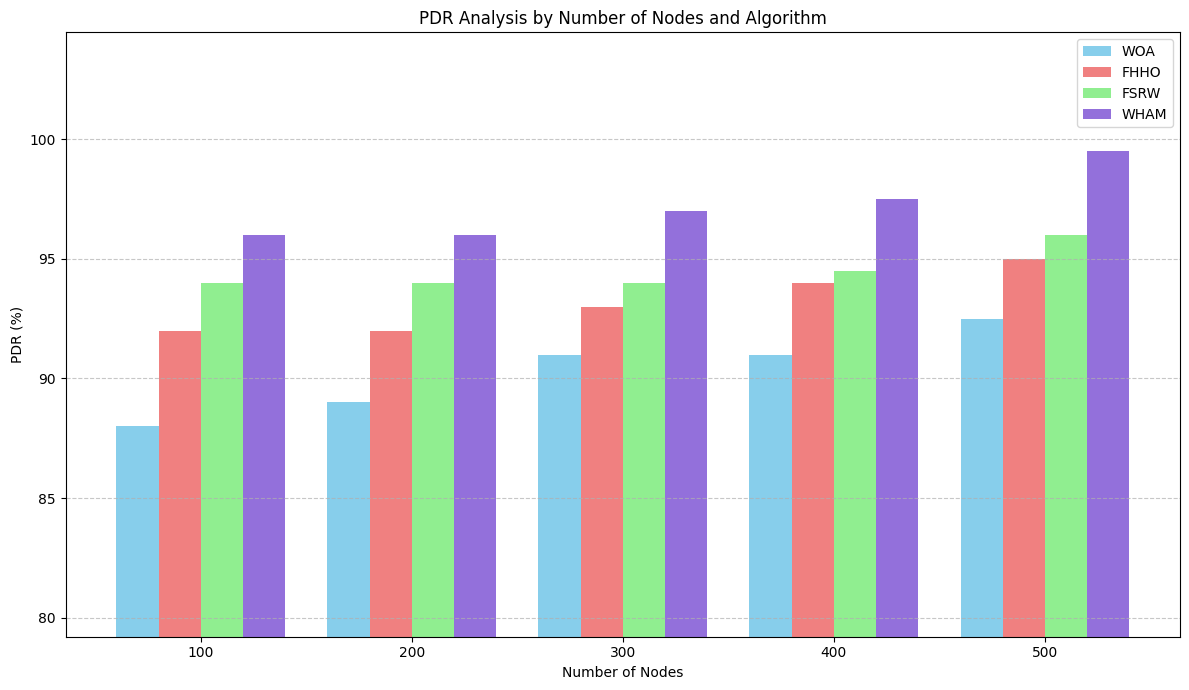

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure pdr_df is available (excluding the average row if it was appended)
# If pdr_df_with_average was used previously, we need to get the original df
if 'pdr_df' in locals():
    plot_df_pdr = pdr_df
else:
    # Fallback if pdr_df was not explicitly kept separate from pdr_df_with_average
    # This assumes the last row of pdr_df_with_average is the average
    plot_df_pdr = pdr_df_with_average.iloc[:-1].copy()

# Convert relevant columns to numeric, handling potential empty strings from average row
plot_df_pdr['WOA PDR'] = pd.to_numeric(plot_df_pdr['WOA PDR'], errors='coerce')
plot_df_pdr['FHHO PDR'] = pd.to_numeric(plot_df_pdr['FHHO PDR'], errors='coerce')
plot_df_pdr['FSRW PDR'] = pd.to_numeric(plot_df_pdr['FSRW PDR'], errors='coerce')
plot_df_pdr['WHAM PDR'] = pd.to_numeric(plot_df_pdr['WHAM PDR'], errors='coerce')

n_nodes_pdr = plot_df_pdr['Nodes'].tolist()
woa_pdr = plot_df_pdr['WOA PDR'].tolist()
fhho_pdr = plot_df_pdr['FHHO PDR'].tolist()
fsrw_pdr = plot_df_pdr['FSRW PDR'].tolist()
wham_pdr = plot_df_pdr['WHAM PDR'].tolist()

x = np.arange(len(n_nodes_pdr))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

rects1 = ax.bar(x - 1.5*width, woa_pdr, width, label='WOA', color='skyblue')
rects2 = ax.bar(x - 0.5*width, fhho_pdr, width, label='FHHO', color='lightcoral')
rects3 = ax.bar(x + 0.5*width, fsrw_pdr, width, label='FSRW', color='lightgreen')
rects4 = ax.bar(x + 1.5*width, wham_pdr, width, label='WHAM', color='mediumpurple')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('PDR (%)')
ax.set_title('PDR Analysis by Number of Nodes and Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(n_nodes_pdr)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(bottom=min(min(woa_pdr), min(fhho_pdr), min(fsrw_pdr), min(wham_pdr)) * 0.9)

# Function to add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function for all sets of bars
# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)
# autolabel(rects4)

fig.tight_layout()
plt.show()

In [57]:
import pandas as pd


delay_data = [
    {'Sl No': 1, 'No of Nodes': 100, 'WOA': 6.2, 'FHHO': 6.0, 'FSRW': 5.8, 'WHAM': 5.7, 'Difference': 0.6, '%': 8},
    {'Sl No': 2, 'No of Nodes': 200, 'WOA': 6.2, 'FHHO': 6.0, 'FSRW': 5.9, 'WHAM': 5.8, 'Difference': 0.4, '%': 6},
    {'Sl No': 3, 'No of Nodes': 300, 'WOA': 6.4, 'FHHO': 6.1, 'FSRW': 6.0, 'WHAM': 5.9, 'Difference': 0.5, '%': 7},
    {'Sl No': 4, 'No of Nodes': 400, 'WOA': 6.5, 'FHHO': 6.3, 'FSRW': 6.2, 'WHAM': 6.1, 'Difference': 0.4, '%': 6},
    {'Sl No': 5, 'No of Nodes': 500, 'WOA': 6.9, 'FHHO': 6.8, 'FSRW': 6.8, 'WHAM': 6.5, 'Difference': 0.9, '%': 5}
]

# Create a DataFrame from the delay data
delay_df = pd.DataFrame(delay_data)

# Calculate the average of the '%' column
average_percentage = delay_df['%'].mean()

# Create a new row for the average
average_row = {
    'Sl No': '',
    'No of Nodes': 'Average',
    'WOA': '',
    'FHHO': '',
    'FSRW': '',
    'WHAM': '',
    'Difference': '',
    '%': average_percentage
}

# Append the average row to the DataFrame
delay_df_with_average = pd.concat([delay_df, pd.DataFrame([average_row])], ignore_index=True)

# Print the DataFrame as a formatted table
print("Delay Analysis (ms):")
print(delay_df_with_average.to_string(index=False))

Delay Analysis (ms):
Sl No No of Nodes  WOA FHHO FSRW WHAM Difference   %
    1         100  6.2  6.0  5.8  5.7        0.6 8.0
    2         200  6.2  6.0  5.9  5.8        0.4 6.0
    3         300  6.4  6.1  6.0  5.9        0.5 7.0
    4         400  6.5  6.3  6.2  6.1        0.4 6.0
    5         500  6.9  6.8  6.8  6.5        0.9 5.0
          Average                                6.4


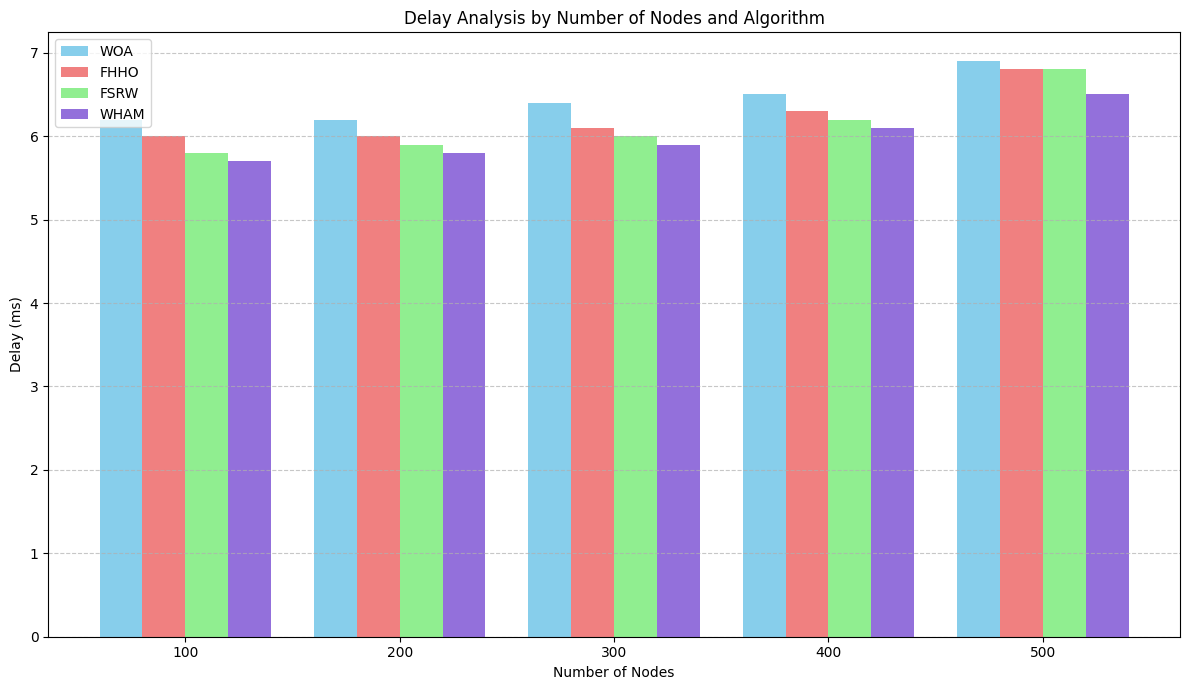

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure delay_df is available (excluding the average row if it was appended)
# If delay_df_with_average was used previously, we need to get the original df
if 'delay_df' in locals():
    plot_df_delay = delay_df
else:
    # Fallback if delay_df was not explicitly kept separate from delay_df_with_average
    # This assumes the last row of delay_df_with_average is the average
    plot_df_delay = delay_df_with_average.iloc[:-1].copy()

# Convert relevant columns to numeric, handling potential empty strings from average row
plot_df_delay['WOA'] = pd.to_numeric(plot_df_delay['WOA'], errors='coerce')
plot_df_delay['FHHO'] = pd.to_numeric(plot_df_delay['FHHO'], errors='coerce')
plot_df_delay['FSRW'] = pd.to_numeric(plot_df_delay['FSRW'], errors='coerce')
plot_df_delay['WHAM'] = pd.to_numeric(plot_df_delay['WHAM'], errors='coerce')

n_nodes_delay = plot_df_delay['No of Nodes'].tolist()
woa_delay = plot_df_delay['WOA'].tolist()
fhho_delay = plot_df_delay['FHHO'].tolist()
fsrw_delay = plot_df_delay['FSRW'].tolist()
wham_delay = plot_df_delay['WHAM'].tolist()

x = np.arange(len(n_nodes_delay))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

rects1 = ax.bar(x - 1.5*width, woa_delay, width, label='WOA', color='skyblue')
rects2 = ax.bar(x - 0.5*width, fhho_delay, width, label='FHHO', color='lightcoral')
rects3 = ax.bar(x + 0.5*width, fsrw_delay, width, label='FSRW', color='lightgreen')
rects4 = ax.bar(x + 1.5*width, wham_delay, width, label='WHAM', color='mediumpurple')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Delay (ms)')
ax.set_title('Delay Analysis by Number of Nodes and Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(n_nodes_delay)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function for all sets of bars
# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)
# autolabel(rects4)

fig.tight_layout()
plt.show()

In [59]:
import pandas as pd


throughput_data = [
    {'Sl No': 1, 'No of Nodes': 100, 'WOA': 88, 'FHHO': 90, 'FSRW': 92, 'WHAM': 96, 'Improvements': 8},
    {'Sl No': 2, 'No of Nodes': 200, 'WOA': 87, 'FHHO': 88, 'FSRW': 91, 'WHAM': 94, 'Improvements': 7},
    {'Sl No': 3, 'No of Nodes': 300, 'WOA': 84, 'FHHO': 86, 'FSRW': 88, 'WHAM': 92, 'Improvements': 8},
    {'Sl No': 4, 'No of Nodes': 400, 'WOA': 84, 'FHHO': 85, 'FSRW': 87, 'WHAM': 91, 'Improvements': 7},
    {'Sl No': 5, 'No of Nodes': 500, 'WOA': 84, 'FHHO': 85, 'FSRW': 86, 'WHAM': 90, 'Improvements': 6}
]


throughput_df = pd.DataFrame(throughput_data)

# Calculate the average of the 'Improvements' column
average_improvements = throughput_df['Improvements'].mean()

# Create a new row for the average
average_row_throughput = {
    'Sl No': '',
    'No of Nodes': 'Average',
    'WOA': '',
    'FHHO': '',
    'FSRW': '',
    'WHAM': '',
    'Improvements': average_improvements
}

# Append the average row to the DataFrame
throughput_df_with_average = pd.concat([throughput_df, pd.DataFrame([average_row_throughput])], ignore_index=True)

# Print the DataFrame as a formatted table
print("Throughput Analysis:")
print(throughput_df_with_average.to_string(index=False))

Throughput Analysis:
Sl No No of Nodes WOA FHHO FSRW WHAM  Improvements
    1         100  88   90   92   96           8.0
    2         200  87   88   91   94           7.0
    3         300  84   86   88   92           8.0
    4         400  84   85   87   91           7.0
    5         500  84   85   86   90           6.0
          Average                              7.2


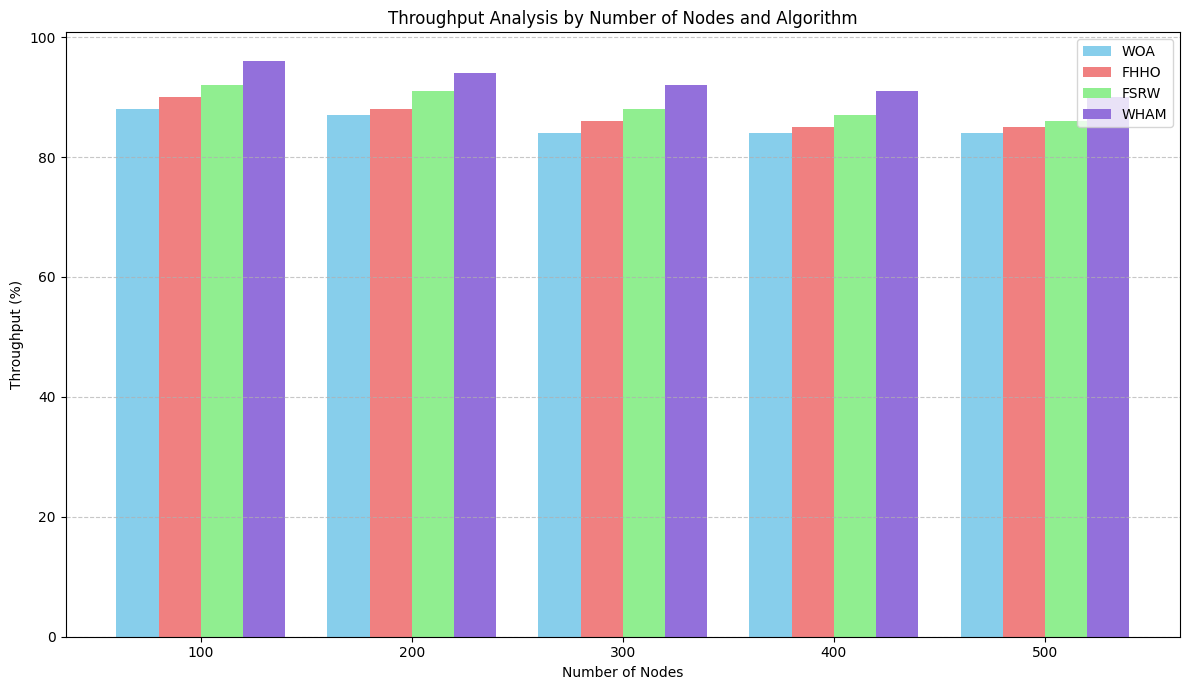

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure throughput_df is available (excluding the average row if it was appended)
# If throughput_df_with_average was used previously, we need to get the original df
if 'throughput_df' in locals():
    plot_df = throughput_df
else:
    # Fallback if throughput_df was not explicitly kept separate from throughput_df_with_average
    # This assumes the last row of throughput_df_with_average is the average
    plot_df = throughput_df_with_average.iloc[:-1].copy()

# Convert relevant columns to numeric, handling potential empty strings from average row
plot_df['WOA'] = pd.to_numeric(plot_df['WOA'], errors='coerce')
plot_df['FHHO'] = pd.to_numeric(plot_df['FHHO'], errors='coerce')
plot_df['FSRW'] = pd.to_numeric(plot_df['FSRW'], errors='coerce')
plot_df['WHAM'] = pd.to_numeric(plot_df['WHAM'], errors='coerce')

n_nodes = plot_df['No of Nodes'].tolist()
woa_throughput = plot_df['WOA'].tolist()
fhho_throughput = plot_df['FHHO'].tolist()
fsrw_throughput = plot_df['FSRW'].tolist()
wham_throughput = plot_df['WHAM'].tolist()

x = np.arange(len(n_nodes))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

rects1 = ax.bar(x - 1.5*width, woa_throughput, width, label='WOA', color='skyblue')
rects2 = ax.bar(x - 0.5*width, fhho_throughput, width, label='FHHO', color='lightcoral')
rects3 = ax.bar(x + 0.5*width, fsrw_throughput, width, label='FSRW', color='lightgreen')
rects4 = ax.bar(x + 1.5*width, wham_throughput, width, label='WHAM', color='mediumpurple')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Throughput (%)')
ax.set_title('Throughput Analysis by Number of Nodes and Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(n_nodes)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function for all sets of bars
# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)
# autolabel(rects4)

fig.tight_layout()
plt.show()
